#### **0. Import Libraries and define Options**

***Import Libraries***

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import scipy.stats
import warnings
warnings.filterwarnings('ignore')

***Define some hyperparameters***

---
$$
    \text{Hyperparamerters you should define}
$$
---

In [2]:
# Set initial Training samples
# IDX_INIT_MODEL = 25253
# IDX_INIT_MODEL = 25000
# IDX_INIT_MODEL = 20000
# IDX_INIT_MODEL = 15000
IDX_INIT_MODEL = 10000

# Optimal PC Selection Method
cv_types = ["full"]

# Significance level for setting threshold
# 99.7% inlier and 1% outlier
alpha = [0.95, 0.997] # 95%, 99.7%

# Define type of anomaly detection
# col_interest = ['CG_1', 'CG_2', 'TT_1', 'TT_2'] # Multivariate analysis
col_interest = ['CG_1'] # unitvariate analysis
max_n_comp_GMM = len(col_interest) + 3 # Empirical set-up

---

#### **1. Load Dataset**

In [3]:
import pickle

# load
fn_load = 'J_Dataset_1101_0630_outlier_3sig'

with open(fn_load + '.pickle', 'rb') as f:
    data = pickle.load(f)

fn = data['fn']
damage_ind = data['damage_ind']
df1, df3 = data['data'][0], data['data'][1]

#### **2. Set Dataset (Train & Test)**

***Define Dataset***

In [4]:
if int(col_interest[0][-1:]) < 3:
    col_list = ['Time', 'CG_1', 'CG_2', 'TT_1', 'TT_2']
    df = df1[col_list]
    Label = df1.Label.values

else:
    col_list = ['Time', 'CG_3', 'CG_4', 'TT_3', 'TT_4']
    df = df3[col_list]
    Label = df3.Label.values

X_all = df.values[:, 1:]

***Reduce the sequence of dataset (too many samples)***

<font color= 'red'><B>
sample should be reduced for computational issues in this tutorial. In reality, it doesn't matter becauses of online implemtation.
</font></B>

In [5]:
n_skip = 10

def reduce_sequence_by_skip(n_skip, dat):
    if isinstance(dat, pd.DataFrame):
        dat = dat.iloc[::n_skip, :]
    else:
        if dat.ndim == 1:
            dat = dat[::n_skip,]
        else:
            dat = dat[::n_skip, :]
        
    return dat

Label = reduce_sequence_by_skip(n_skip, Label)
X_all = reduce_sequence_by_skip(n_skip, X_all)
df = reduce_sequence_by_skip(n_skip, df)

IDX_INIT_MODEL = int(IDX_INIT_MODEL/n_skip)
df = df.reset_index()

***Find damage index as # index of sample***

In [6]:
damage_ind = []
for ind_label in np.unique(Label):
    if ind_label != 0:
        ind_damage = np.where(Label == ind_label)[0][0]
        damage_ind.append(ind_damage)
damage_ind

[2526, 2972]

***Plot Ground Truth (label)***

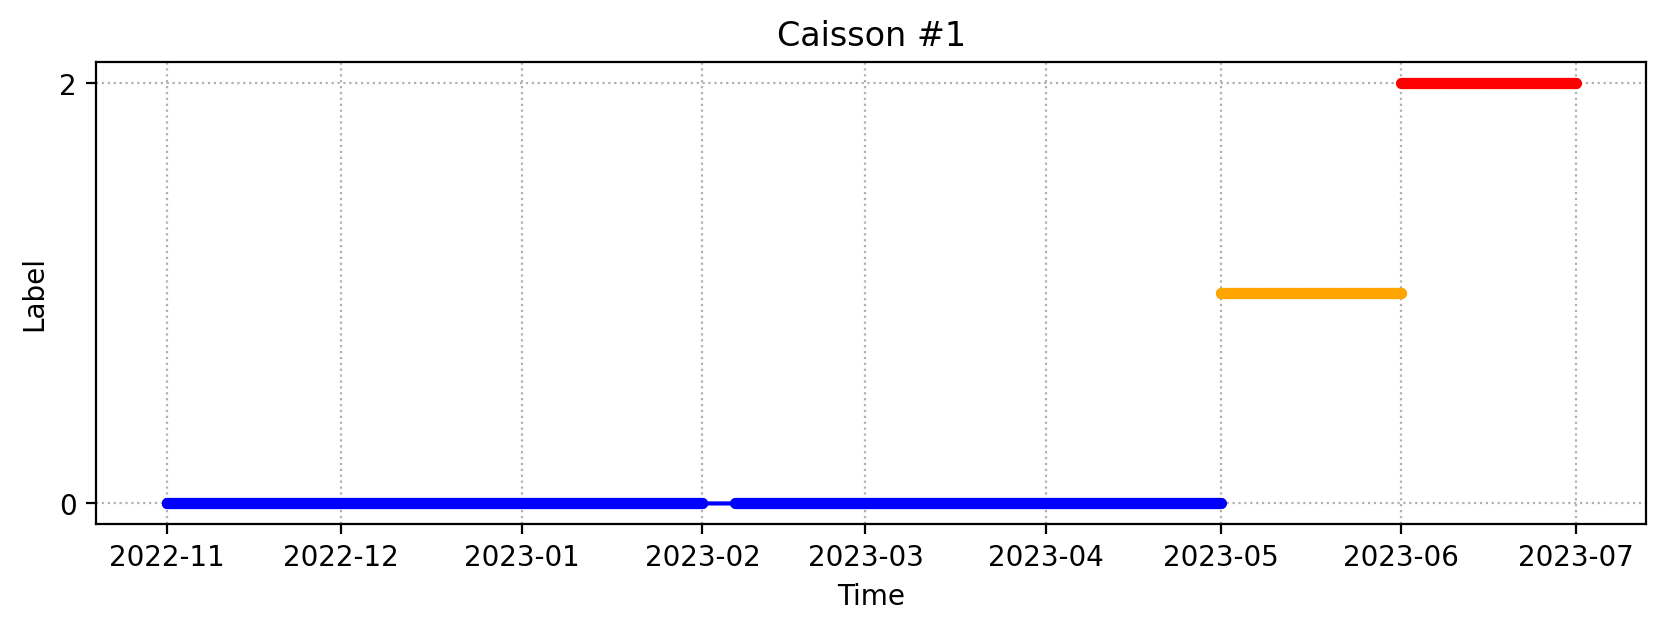

In [7]:
# Plot scatter plot (Time index vs. Label)
color_type_str = ['blue', 'orange', 'red']

plt.figure(figsize = (10, 3), dpi = 200)
for label_ind in np.unique(Label):
    indice_ = np.where(Label == label_ind)
    plt.plot(df.Time.iloc[indice_], Label[indice_], marker = '.', color = color_type_str[label_ind])
plt.xlabel('Time')
plt.ylabel('Label')
plt.gca().set_yticks([0, label_ind])
plt.grid(linestyle = ':')
if 'CG_1' in df.columns:
    struct_type = 'Caisson #1'
else:
    struct_type = 'Caisson #3'

plt.title(struct_type)
plt.show()

***Define Training and Test Dataset***

In [8]:
# Set last index for normal state
IDX_NORMAL = damage_ind[0]

if IDX_INIT_MODEL > IDX_NORMAL:
    IDX_INIT_MODEL = IDX_NORMAL
    print(f'Index for Normal state should be less than index of damage {damage_ind[0]}')

# For Allocation of memory
SIZE_ALL = X_all.shape[0]

***Plot Rawdata in line plot***

In [9]:
if 0:
    color_type_str = ['blue', 'orange', 'red']

    for col_ind in range(X_all.shape[1]):
        plt.figure(figsize = (10, 3), dpi = 200)
        for label_ind in np.unique(Label):
            row_ind = np.where(Label == label_ind)
            plt.plot(df.Time.iloc[row_ind], X_all[row_ind, col_ind].reshape(-1, 1),
                    marker = '.', color = color_type_str[label_ind])
        plt.xlabel('Time')
        plt.ylabel(list(df.columns[1:])[col_ind])
        plt.grid(linestyle = ':')
        plt.title(struct_type)
        plt.show()

#### **3. Set Initial Dataset & Scaling (Standardization)**

In [10]:
# Set initial Training samples
print(f'Variables = {col_interest}')

Variables = ['CG_1']


***Set Initial Traininigset and Testset***

Make dataset and result in the form of `Pandas.Dataframe` structure

In [11]:
import pandas as pd

df_all = df[col_interest]
df_all['labels'] = Label
df_all['Anomaly_Score'] = 0
df_all['Is_anomaly_95'], df_all['Is_anomaly_99'] = 0, 0
df_all

df_train = df_all.iloc[0:IDX_INIT_MODEL,:]
df_test = df_all.iloc[IDX_INIT_MODEL:,:]

#### **4. Construct Baseline model using initial trainig dataset**

***Define some Helper functions***

- Fitting GMM with model selection framework based on BIC

In [12]:
def fit_best_GMM(X, n_comp_min = 1, n_comp_max = 5, cv_types = ["spherical", "tied", "diag", "full"]):
    import numpy as np
    import itertools

    from scipy import linalg
    import matplotlib.pyplot as plt
    import matplotlib as mpl

    from sklearn import mixture

    if X.shape[1] == 1:
        cv_types = 'Uni'

    lowest_bic = np.infty
    fitted_gmms, bic = [], []
    n_components_range = range(n_comp_min, n_comp_max)
    cv_types = cv_types
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            if X.shape[1] == 1:
                gmm = mixture.GaussianMixture(n_components = n_components)
            else:
                gmm = mixture.GaussianMixture(
                    n_components = n_components, covariance_type = cv_type)
            gmm.fit(X)
            fitted_gmms.append(gmm)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    return fitted_gmms, best_gmm, bic

- Compute anomaly score (log-likelihood) and threshold

In [13]:
def compute_anomaly_score(Xtrain_scaled, best_gmm):
    # Get the anomaly score for training data
    return best_gmm.score_samples(Xtrain_scaled)

In [14]:
def compute_threshold(Xtrain_scaled, best_gmm, alpha):
    # Get the anomaly score for training data
    score = compute_anomaly_score(Xtrain_scaled, best_gmm)
    
    # Compute threshold from training data with significant level
    significance_level = 1 - alpha[0] # 95% inlier and 5% outlier
    pct_threshold95 = np.percentile(score, significance_level) # 99% significnace level

    significance_level = 1 - alpha[1] # 95% inlier and 5% outlier
    pct_threshold99 = np.percentile(score, significance_level) # 99% significnace level
    
    return pct_threshold95, pct_threshold99

- Evaluate anomaly based on score and threshold

In [15]:
def evaluate_anomaly(score, pct_threshold):
    return score < pct_threshold

- Plot function for display anomly dectection result

In [16]:
# Plot lnliers and outliers
def plot_anomaly_detection_result(df_train, df_threshold):
    outliers95, outliers99 = df_train['Is_anomaly_95'], df_train['Is_anomaly_99']
    
    # print(f'outlier ratio w/ threshold 95%: {outliers95.sum()/df_train.shape[0] * 100:.2f} %')    
    fig, ax = plt.subplots(2, 1, figsize = (10, 6), dpi = 200)
    markerline, stemlines, baseline = ax[0].stem(df_train.index, df_train['Anomaly_Score'])
    plt.setp(markerline, 'markersize', 1, 'color', 'k')
    plt.setp(stemlines, 'linestyle', '-', 'linewidth', 0.5, 'alpha', 0.1)
    plt.setp(baseline, 'color', 'k')
    ax[0].plot(df_train.index[outliers95], df_train.loc[outliers95, 'Anomaly_Score'], 'ro', ls = 'None', label = 'outliers')
    ax[0].plot(df_threshold['Threshold_95'], color = '#DFA290')
    ax[0].set_title(f'# outliers: {outliers99.sum()} // # inliers: {df_train.shape[0] - outliers95.sum()} with {alpha[0]*100} %')
    # plt.show()

    # print(f'outlier ratio w/ threshold 99%: {outliers99.sum()/df_train.shape[0] * 100:.2f} %')
    # plt.figure(figsize = (10, 3), dpi = 200)
    markerline, stemlines, baseline = ax[1].stem(df_train.index, df_train['Anomaly_Score'])
    plt.setp(markerline, 'markersize', 1, 'color', 'k')
    plt.setp(stemlines, 'linestyle', '-', 'linewidth', 0.5, 'alpha', 0.1)
    plt.setp(baseline, 'color', 'k')
    ax[1].plot(df_train.index[outliers99], df_train.loc[outliers99, 'Anomaly_Score'], 'ro', ls = 'None', label = 'outliers')
    ax[1].plot(df_threshold['Threshold_99'], color = '#DFA290')
    ax[1].set_title(f'# outliers: {outliers99.sum()} // # inliers: {df_train.shape[0] - outliers95.sum()} with {alpha[1]*100} %')
    fig.tight_layout()
    plt.show()

***Options for COV-type in GMM***

<center> <p>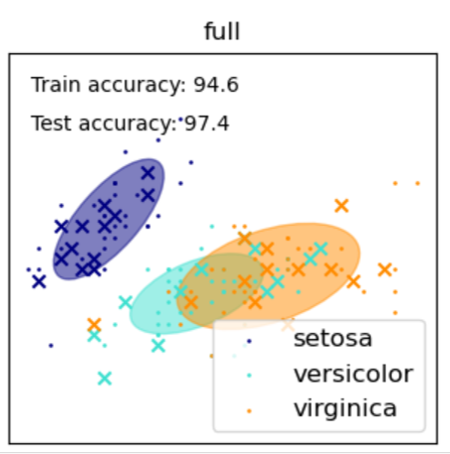</p> </center>

> To simplify fitting stage, we consider only `full` covariance type

***Fit initial GMM as Baseline model***

- *Define standardizer (scaling)*

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xtrain = df_train.iloc[:, :len(col_interest)].values
Xtrain_scaled = scaler.fit_transform(Xtrain)

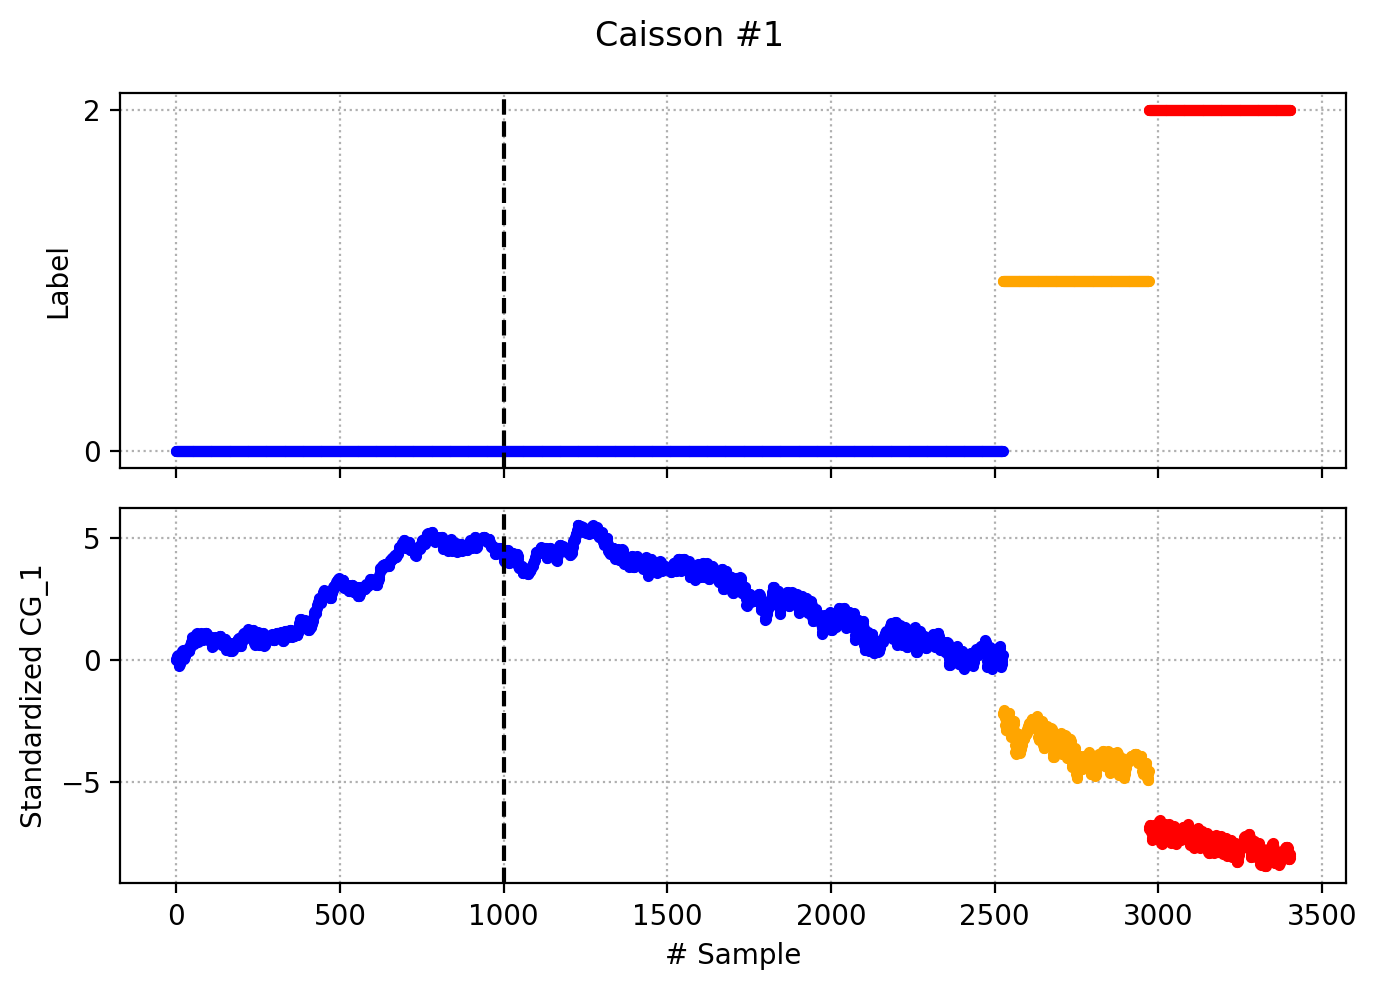

In [18]:
color_type_str = ['blue', 'orange', 'red']
for col_ind in col_interest:
    fig, ax = plt.subplots(2, 1, figsize = (7, 5), dpi = 200, sharex = True)
    for label_ind in np.unique(Label):
        row_ind = np.where(Label == label_ind)
        ax[0].plot(row_ind[0], df_all.iloc[row_ind]['labels'],
                marker = '.', color = color_type_str[label_ind])

        ax[1].plot(row_ind[0], df_all.iloc[row_ind][col_ind],
                marker = '.', color = color_type_str[label_ind])
    
    ax[0].set_ylabel('Label')
    ax[0].set_yticks([0, label_ind])
    ax[0].grid(linestyle = ':')
    ax[0].axvline(x = IDX_INIT_MODEL, color = 'k', linestyle = '--', label = 'End of trainset')

    ax[1].set_xlabel('# Sample')
    ax[1].set_ylabel(f'Standardized {col_ind}')
    ax[1].axvline(x = IDX_INIT_MODEL, color = 'k', linestyle = '--', label = 'End of trainset')
    ax[1].grid(linestyle = ':')
    plt.suptitle(struct_type)
    fig.tight_layout()
    plt.show()


- *Fit GMM with model selection framework*

In [19]:
# Automatic model selection for GMM
fitted_gmm, best_gmm, bics = fit_best_GMM(Xtrain_scaled,
                                        n_comp_min = 1, n_comp_max = max_n_comp_GMM,
                                        cv_types = cv_types)

df_gmm = []
for gmm, bic in zip(fitted_gmm, bics):
    df_gmm.append([gmm.covariance_type, gmm.n_components, bic])
df_gmm = pd.DataFrame(df_gmm, columns = ['covariance_type', 'n_component', 'bic'])
df_gmm.sort_values(by=['bic'], ignore_index = True)

print(f'[Best GMM] Cov_type:  {best_gmm.covariance_type} // # Opt. comp.: {best_gmm.n_components}')

[Best GMM] Cov_type:  full // # Opt. comp.: 3


- *Compute anomaly score and threshold*

In [20]:
score = compute_anomaly_score(Xtrain_scaled, best_gmm)

pct_threshold95, pct_threshold99 = compute_threshold(Xtrain_scaled, best_gmm, alpha)

df_train['Anomaly_Score'] = score

df_threshold = pd.DataFrame()
df_threshold.index = df_train.index
df_threshold['Threshold_95'] = pct_threshold95
df_threshold['Threshold_99'] = pct_threshold99

- *Evaluate anomality*

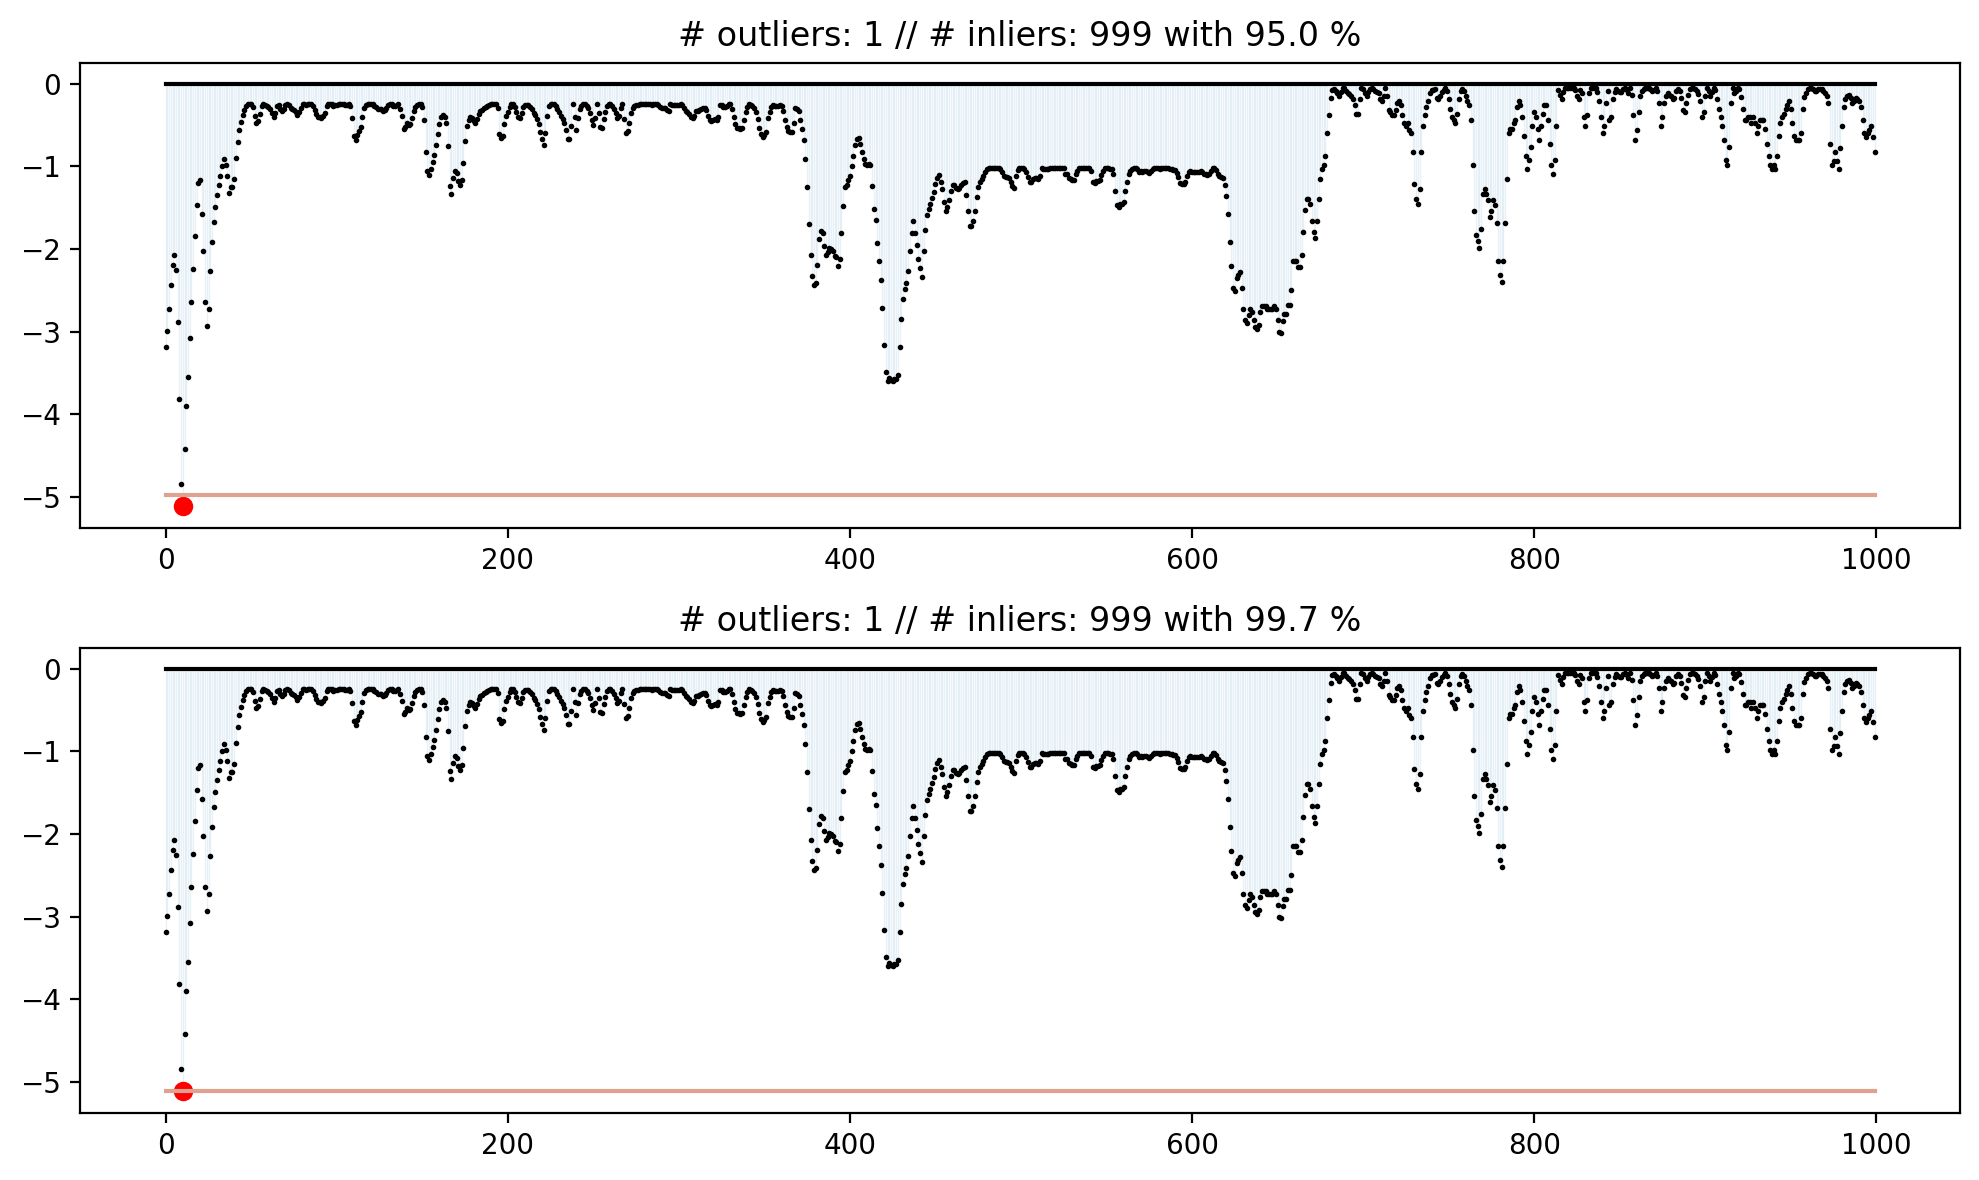

In [21]:
score = df_train['Anomaly_Score']
anomaly_index95 = evaluate_anomaly(score, pct_threshold95)
anomaly_index99 = evaluate_anomaly(score, pct_threshold99)

df_train['Is_anomaly_95'] = anomaly_index95
df_train['Is_anomaly_99'] = anomaly_index99

plot_anomaly_detection_result(df_train, df_threshold)

#### **5. Monitoring Phase (Evaluation Stage)**

***Define some Helper functions***

- Select inlier samples in your trainset (95% threshold is set to reference value)

In [22]:
def select_inliers_from_trainingset(df_train, ref = 'Is_anomaly_99'): # or Is_anomaly_99
    return df_train[df_train[ref] == False]

In [23]:
# Update df_all (look-up table) using initial baseline
df_all.iloc[:df_train.shape[0], :] = df_train.iloc[:df_train.shape[0], :]

# Monitoring phase
ind_start, ind_end, ind_step = df_train.shape[0], df_all.shape[0], 100
for ind in range(ind_start, ind_end, ind_step): # Monitoring phase (herein, testset)
    if ind + ind_step > ind_end:
        ind_ = list(range(ind, ind_end))
    else:
        ind_ = list(range(ind, ind + ind_step))

    # print(f'{ind}/{df_all.shape[0]}', end = '\r')
    ## 1. Evaluate New sample ##
    # Evaluate whether if new samples is inlier or not?
    ###################################
    # 1-1) Select new sample
    ###################################
    df_new = df_all.iloc[ind_, :]
    
    ###################################
    # 1-2) Standardize new sample using scaler of new trainset (scaling)
    ###################################
    x_new = df_new.iloc[:, :len(col_interest)].values # Before standardization (raw)
    if x_new.shape[1] > 1:
        x_new_scaled = scaler.transform(x_new) # Standardize new sample (Scaled)
    else:
        x_new_scaled = scaler.transform(x_new.reshape(-1, 1)) # Standardize new sample (Scaled)

    ###################################
    # 1-3) Compute anomaly score using baseline model(GMM)
    ###################################
    score_new = compute_anomaly_score(x_new_scaled, best_gmm)
    # Update infromation of df_new
    df_new['Anomaly_Score'] = score_new # score_new[0]
    df_new['Is_anomaly_95'] = evaluate_anomaly(score_new, pct_threshold95)
    df_new['Is_anomaly_99'] = evaluate_anomaly(score_new, pct_threshold99)
    
    # Update df_thresh
    tmp_thresh = np.hstack(
        (np.ones((df_new.shape[0], 1)).reshape(-1, 1) * pct_threshold95, 
        np.ones((df_new.shape[0], 1)).reshape(-1, 1) * pct_threshold99))
    tmp_thresh_ = pd.DataFrame(tmp_thresh, columns = list(df_threshold.columns))
    df_threshold = pd.concat([df_threshold, tmp_thresh_], axis = 0, ignore_index = True)
    
    # Update our look-up table (df_all) for new sample
    df_all.iloc[ind_] = df_new

    ###################################
    # 2) Waypoint according to anomaly result 
    ###################################
    
    if df_new['Is_anomaly_99'].to_numpy()[0]: # New sample is anomaly => Keep baseline model
        # Do nothing! and Just turn around!
        continue
    else: # New sample is not anomaly => Update baseline model
        
        ## 2. Update Baseline model ##
        # 2-1) Adding new sample to the current trainingset
        ###################################
        df_train = pd.concat([df_train, df_new], axis = 0, ignore_index = True)

        # 2-2) Define new trainset based on anomaly detection result
        ###################################
        # df_train_new = select_inliers_from_trainingset(df_train, ref = 'Is_anomaly_95')
        df_train_new = select_inliers_from_trainingset(df_train, ref = 'Is_anomaly_99')

        ###################################
        # 2-3) Standardization of new trainset (scaling)
        ###################################
        Xtrain_new = df_train_new.iloc[:, :len(col_interest)].values
        Xtrain_new_scaled = scaler.fit_transform(Xtrain_new)

        ###################################
        # 2-4) Update our baseline model (GMM) with new trainset
        ###################################
        # Automatic model selection for GMM
        _, best_gmm, bics = fit_best_GMM(Xtrain_new_scaled,
                                            n_comp_min = 1, n_comp_max = max_n_comp_GMM,
                                            cv_types = cv_types)

        ###################################
        # 2-5) Update threshold based on new trainset
        ###################################
        pct_threshold95, pct_threshold99 = compute_threshold(Xtrain_new_scaled, best_gmm, alpha)

- Comformal prediction => stoppting criteria => based on significance level (alpha)

In [24]:
def plot_final_result(df_all, df_threshold, IDX_INIT_MODEL, col_interest, ref_thresh = 'Threshold_99'):
    Label = df_all['labels'].values
    color_type_str = ['blue', 'orange', 'red']

    for col_ind in col_interest:
        # Share both X and Y axes with all subplots
        _, ax = plt.subplots(3, 1, sharex='all', figsize = (10, 6), dpi = 200)
        for label_ind in np.unique(Label):
            row_ind = np.where(Label == label_ind)
            ax[0].plot(row_ind[0], df_all.iloc[row_ind][col_ind],
                    marker = '.', color = color_type_str[label_ind], markersize = 1)
        ax[0].axvline(x = IDX_INIT_MODEL, color = 'c', linestyle = '--', label = 'End of trainset')
        ax[0].grid(linestyle = ':')
        ax[0].set_ylabel(f'{col_ind}')
    for ind_damage_ in damage_ind:
        ax[0].axvline(x = ind_damage_, color = 'r', linestyle = '--', label = 'Abnormal Event')
    ax[0].legend(loc = 'best')

    alpha = int(ref_thresh[-2:])

    col_thresh = f'Is_anomaly_{alpha}'
    outlier_index = df_all[col_thresh]

    markerline, stemlines, baseline = ax[1].stem(df_all.index, df_all['Anomaly_Score'])
    plt.setp(markerline, 'markersize', 0.5, 'color', 'k')
    plt.setp(stemlines, 'linestyle', '-', 'linewidth', 0.5, 'alpha', 0.1)
    plt.setp(baseline, 'color', 'k')
    ax[1].plot(df_all.index[outlier_index], df_all.loc[outlier_index, 'Anomaly_Score'], 'ro',
            markersize = 1, ls = 'None', label = 'outliers')
    ax[1].plot(df_threshold[ref_thresh], linestyle = '--', color = '#DFA290')
    ax[1].axvline(x = IDX_INIT_MODEL, color = 'c', linestyle = '--')
    ax[1].grid(linestyle = ':')
    ax[1].set_ylabel('Anomaly Score')
    ax[1].set_ylim([df_threshold[ref_thresh].values.min() - 2, 1])
    ax[1].set_xlabel(f'# Sample')
    for ind_damage_ in damage_ind:
        ax[1].axvline(x = ind_damage_, color = 'r', linestyle = '--')
    ax[1].legend(loc = 'best')

    markerline, stemlines, baseline = ax[2].stem(df_all.index, df_all['Anomaly_Score'])
    plt.setp(markerline, 'markersize', 0.5, 'color', 'k')
    plt.setp(stemlines, 'linestyle', '-', 'linewidth', 0.5, 'alpha', 0.1)
    plt.setp(baseline, 'color', 'k')
    ax[2].plot(df_all.index[outlier_index], df_all.loc[outlier_index, 'Anomaly_Score'], 'ro',
            markersize = 1, ls = 'None', label = 'outliers')
    ax[2].plot(df_threshold[ref_thresh], linestyle = '--', color = '#DFA290')
    ax[2].axvline(x = IDX_INIT_MODEL, color = 'c', linestyle = '--')
    ax[2].grid(linestyle = ':')
    ax[2].set_ylabel('Anomaly Score')
    ax[2].set_xlabel(f'# Sample')
    for ind_damage_ in damage_ind:
        ax[2].axvline(x = ind_damage_, color = 'r', linestyle = '--')
    ax[2].legend(loc = 'best')
    
    plt.suptitle(f'Anomaly detection with alpha = {ref_thresh[-2:]} %')
    plt.show()

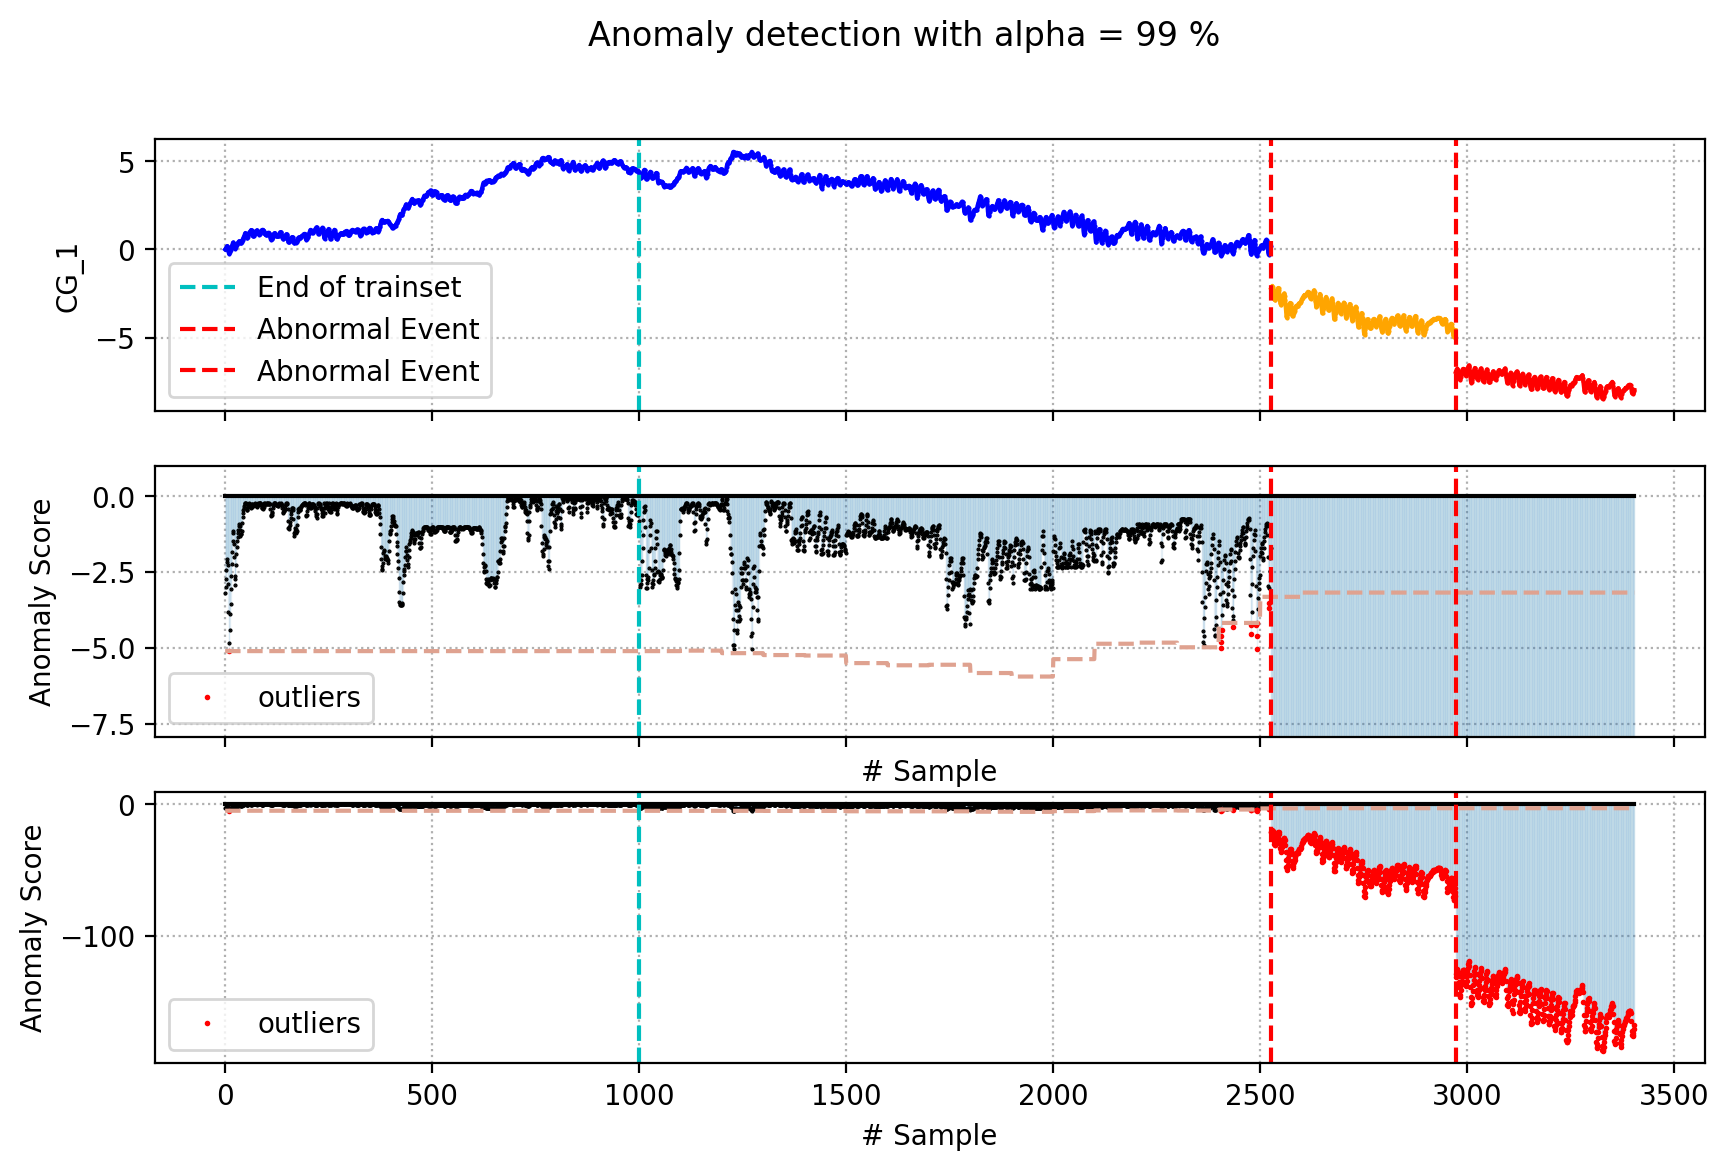

In [25]:
plot_final_result(df_all, df_threshold, IDX_INIT_MODEL, col_interest, ref_thresh = 'Threshold_99')

https://colab.research.google.com/drive/1uRsj9GvF-MJrnEYvBczqSBDnJpTmFWAX?usp=sharing#scrollTo=DzfvD21_YumL